In [ ]:
import pandas as pd
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/datasets/FaceExtractions_FaceForensics++.zip

Streaming output truncated to the last 5000 lines.
  inflating: FaceExtractions_FaceForensics++/validation/real/frameFJHQZ.jpg  
  inflating: FaceExtractions_FaceForensics++/validation/real/frameFJHRA.jpg  
  inflating: FaceExtractions_FaceForensics++/validation/real/frameFJHRB.jpg  
  inflating: FaceExtractions_FaceForensics++/validation/real/frameFJHRC.jpg  
  inflating: FaceExtractions_FaceForensics++/validation/real/frameFJHRD.jpg  
  inflating: FaceExtractions_FaceForensics++/validation/real/frameFJHRE.jpg  
  inflating: FaceExtractions_FaceForensics++/validation/real/frameFJHRF.jpg  
  inflating: FaceExtractions_FaceForensics++/validation/real/frameFJHRG.jpg  
  inflating: FaceExtractions_FaceForensics++/validation/real/frameFJHRH.jpg  
  inflating: FaceExtractions_FaceForensics++/validation/real/frameFJHRI.jpg  
  inflating: FaceExtractions_FaceForensics++/validation/real/frameFJHRJ.jpg  
  inflating: FaceExtractions_FaceForensics++/validation/real/frameFJHRK.jpg  
  inflating: 

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0,
                             validation_split=0.1)

train = datagen.flow_from_directory('FaceExtractions_FaceForensics++/train',
                                    class_mode='binary',
                                    batch_size=75,
                                    target_size=(256,256))

validation = datagen.flow_from_directory('FaceExtractions_FaceForensics++/validation',
                                    class_mode='binary',
                                    batch_size=75,
                                    target_size=(256,256))

test = datagen.flow_from_directory('FaceExtractions_FaceForensics++/test',
                                    class_mode='binary',
                                    batch_size=75,
                                    target_size=(256,256))

Found 2061767 images belonging to 2 classes.
Found 126093 images belonging to 2 classes.
Found 132573 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, LeakyReLU
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
i = Input(shape=(256, 256, 3))
x = Conv2D(8, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
 
x = Conv2D(8, (5, 5), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
 
x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((4, 4))(x)
 
x = Flatten()(x)
x = Dropout(0.5)(x)
 
# Hidden layer
x = Dense(16)(x)
x = LeakyReLU(alpha=0.1)(x)

x = Dropout(0.5)(x)
 
# last hidden layer i.e.. output layer
x = Dense(1, activation='sigmoid')(x)
 
model = Model(i, x)
 
# model description
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       1608      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 8)      32    

In [ ]:
from tensorflow.keras.optimizers.schedules import *

class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate):
    self.initial_learning_rate = initial_learning_rate
    self.current_learning_rate = initial_learning_rate
    self.divisions = 0
    self.currentStep = 0

  def __call__(self, step):
    self.currentStep += 1
    if self.currentStep % 1000 == 0:
      self.divisions += 1
      if self.divisions <= 3:
        self.current_learning_rate /= 10
    return self.current_learning_rate


In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['accuracy'])

In [ ]:
from PIL import Image

In [ ]:
history1 = model.fit_generator(generator=train, steps_per_epoch=train.n//75,
                              validation_data=validation, validation_steps=validation.n//75,
                              epochs=3,
                              shuffle=True,
                              verbose=1,
                              use_multiprocessing=True,
                              workers=16
                             )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/3
27490/27490 [==============================] - 9709s 353ms/step - loss: 0.1163 - accuracy: 0.8385 - val_loss: 0.1240 - val_accuracy: 0.8256
Epoch 2/3
27490/27490 [==============================] - 6828s 248ms/step - loss: 0.0921 - accuracy: 0.8724 - val_loss: 0.1074 - val_accuracy: 0.8507
Epoch 3/3
27490/27490 [==============================] - 6875s 250ms/step - loss: 0.0862 - accuracy: 0.8812 - val_loss: 0.1021 - val_accuracy: 0.8579


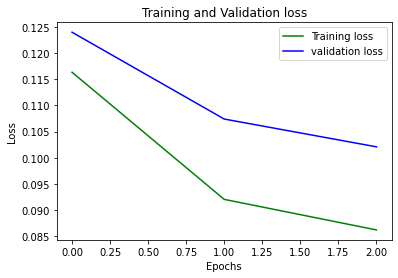

In [ ]:
loss_train = history1.history['loss']
loss_val = history1.history['val_loss']
epochs = range(0,3)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

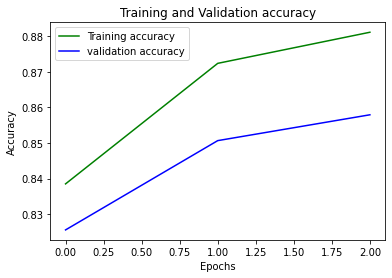

In [ ]:
loss_train = history1.history['accuracy']
loss_val = history1.history['val_accuracy']
epochs = range(0,3)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('model_deepfake')

INFO:tensorflow:Assets written to: model_deepfake/assets


In [ ]:
!zip -r /content/deepfake.zip /content/model_deepfake

  adding: content/model_deepfake/ (stored 0%)
  adding: content/model_deepfake/variables/ (stored 0%)
  adding: content/model_deepfake/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: content/model_deepfake/variables/variables.index (deflated 73%)
  adding: content/model_deepfake/assets/ (stored 0%)
  adding: content/model_deepfake/keras_metadata.pb (deflated 93%)
  adding: content/model_deepfake/saved_model.pb (deflated 89%)


In [ ]:
from google.colab import files
files.download("/content/deepfake.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/models/deepfake_frames/content/model3')

In [ ]:
import numpy as np

In [ ]:
labels = test.class_indices
print(labels)
labels = dict((v,k) for k,v in labels.items())

print(labels)

accuracy = 0
total = 0

y_pred = []
y_act = []

for i in range(len(test)):
  test_img = test[i]
  prediction = model.predict(test_img[0])
  
  # print(prediction)
  for e in range(len(prediction)):
    i += 1
    label = 0
    if prediction[e] > 0.5:
      label = 1
    if label == test_img[1][e]:
      accuracy += 1
    else:
      print(prediction[e], test_img[1][e])
    y_pred.append(label)
    y_act.append(test_img[1][e])
    total += 1

print("Test accuracy is " + str(accuracy / total))


Streaming output truncated to the last 5000 lines.
[0.46304438] 1.0
[0.8071444] 0.0
[0.7741126] 0.0
[0.24772003] 1.0
[0.39513296] 1.0
[0.40580815] 1.0
[0.00018261] 1.0
[0.16069101] 1.0
[0.43664396] 1.0
[0.04074585] 1.0
[0.6024345] 0.0
[0.99192303] 0.0
[0.62591624] 0.0
[0.33171257] 1.0
[0.30748895] 1.0
[0.23893665] 1.0
[0.26504067] 1.0
[0.4004608] 1.0
[0.6888484] 0.0
[0.16964544] 1.0
[0.62866926] 0.0
[0.8747159] 0.0
[0.80821925] 0.0
[0.921605] 0.0
[0.553269] 0.0
[0.15903348] 1.0
[0.88616806] 0.0
[0.08763517] 1.0
[0.8023709] 0.0
[0.8594161] 0.0
[0.5287744] 0.0
[0.38383943] 1.0
[0.6469742] 0.0
[0.08397356] 1.0
[0.16438958] 1.0
[0.3373014] 1.0
[0.29668862] 1.0
[0.28316593] 1.0
[0.70603263] 0.0
[0.5174076] 0.0
[0.87892264] 0.0
[0.3777077] 1.0
[0.20247737] 1.0
[0.3734089] 1.0
[0.533585] 0.0
[0.44052902] 1.0
[0.32805187] 1.0
[0.94302267] 0.0
[0.42371094] 1.0
[0.01231363] 1.0
[0.31742796] 1.0
[0.08372591] 1.0
[0.01518076] 1.0
[0.5932917] 0.0
[0.78378963] 0.0
[0.51699114] 0.0
[0.00990295] 1.0
[

In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_act, y_pred)

print(cf_matrix)

[[98380  9565]
 [11810 12818]]


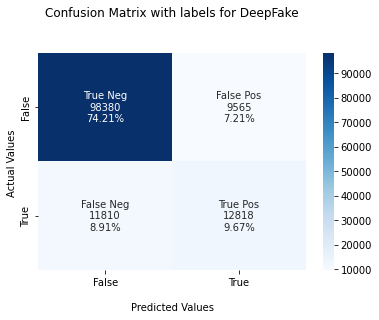

In [ ]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix with labels for DeepFake\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()